## Notebook for exploring the MAE of the visual features
#### Outline
-  Prepare data
    - Load model from checkpoint
    - Get image representations from iNaturalist validation dataset
- Exploring latent space of MAE model

In [14]:
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
from pathlib import Path
import math
import PIL
from PIL import Image
import umap
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import cm
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

import torch
from torch import nn
import torchvision.transforms as transforms
# import torchvision.datasets as datasets
import torchvision.utils as vutils
from util.pos_embed import interpolate_pos_embed
from util import datasets

import models_mae
import models_mae_vsc
import models_vit

print(np.__version__)
print(pd.__version__)
print(torch.__version__)

path_meta = Path('meta')
path_meta.mkdir(exist_ok=True, parents=True)
path_embeddings = Path('embedding')
path_embeddings.mkdir(exist_ok=True, parents=True)

1.22.2
1.4.1
1.10.2+cu113


# Prepare dataset

## Define encoder

In [15]:
encoder_version='eBirdPT_VSC' # 'iNatFT', 'eBirdFT' or 'eBirdPT', 'eBirdPT_VSC'
norm_pixel = 'off' # 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'eBirdTop100' #  'iNat', 'eBird', 'eBirdTop100'
path_model = Path('output_dir')

print(f'Encoder  : {encoder_version}')
if encoder_version=='iNatFT':
    ck = path_model/'ebird_NPon_FT_cls_vit_base_checkpoint-99.pth'   #　iNaturalist finetuned MAE
    n_classes = 1486
elif encoder_version=='eBirdPT':
    ck = path_model/'ebird_LP_cls_2fc_vit_base_checkpoint-89.pth'   #　eBird pretrained MAE
    n_classes =1486
elif encoder_version=='eBirdFT':
    ck = path_model/'ebird_NPon_eBirdFT_cls11186_vit_base_checkpoint-149.pth'  #　eBird finetuned MAE
    n_classes = 11186
elif encoder_version=='eBirdPT_VSC':
    epoch_=400
    ck = path_model/f'VSC_A001_Wr1_Wp5e-3_W40_LRe-5_checkpoint-{epoch_}.pth'  #　eBird finetuned MAE_VSC

v_embedding = f'NP{norm_pixel}(Pretrain)_{encoder_version}_{token}(Encoder)_{data_src}(Data)'
print(f'Embedding version : {v_embedding}')




Encoder  : eBirdPT_VSC
Embedding version : NPoff(Pretrain)_eBirdPT_VSC_cls(Encoder)_eBirdTop100(Data)


#### def load_encoder()

In [16]:
if 'PT' in encoder_version:
    arch = 'mae_vit_base_patch16'
    if 'VSC' in encoder_version:
        model = getattr(models_mae_vsc, arch)()
    else:
        model = getattr(models_mae, arch)()
elif 'FT' in encoder_version:
    arch = 'vit_base_patch16'
    model =  models_vit
    model = models_vit.__dict__[arch](num_classes=n_classes, global_pool=global_pool, )

In [18]:
   
def load_encoder(ck, model_, n_classes:int=None, global_pool:bool=False, encoder_version:str='eBirdPT_VSC', **kwargs):
    
    checkpoint = torch.load(ck, map_location='cpu')
    checkpoint_model = checkpoint['model']
    if 'FT' in encoder_version: 
        state_dict = model.state_dict()
        # interpolate position embedding
        interpolate_pos_embed(model, checkpoint_model)
    # load pre-trained model
    msg = model_.load_state_dict(checkpoint_model, strict=False)
    print(msg)
    
    return model_

print(f"Load pre-trained checkpoint from: {ck}")
encoder = load_encoder(ck, model, encoder_version=encoder_version)

Load pre-trained checkpoint from: output_dir/VSC_A001_Wr1_Wp5e-3_W40_LRe-5_checkpoint-400.pth
<All keys matched successfully>


## load meta

In [20]:
%%time

data_path = '../../shared/iNaturalist_2021'

if data_src == 'eBird':
    val_data = 'val_ebird'
    meta_data =  '../../shared/iNaturalist_2021/meta/val_ebird.csv'
elif data_src == 'iNat':
    val_data = 'val'
    meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
elif  data_src == 'eBirdTop100':
    data_path = '../../shared/eBird/download_ebird/downloaded'
    val_data = 'jpg_top100'
    meta_data =  '../../shared/eBird/download_ebird/meta/jpg_top100_meta5.feather'

print(f'Meta data :  "{Path(meta_data).name}"')

Meta data :  "jpg_top100_meta5.feather"
CPU times: user 151 µs, sys: 21 µs, total: 172 µs
Wall time: 186 µs


In [21]:
%%time

if "feather" in meta_data:
    df_meta =  pd.read_feather(meta_data)
else:
    df_meta =  pd.read_csv(meta_data, index_col=0 )

CPU times: user 2.41 s, sys: 2.81 s, total: 5.22 s
Wall time: 2.44 s


In [22]:
%%time
# Establish sp_id  
if data_src == 'eBirdTop100':
    col_obj2cat = ['Format', 'Accessory', 'Asset_State', 'isInternalUser', 'mediaDownloadUrl', 'Playback', 'Microphone', 'Recorder', 'Taxon_Category', 
                   'Age/Sex', 'Asset_Tags', 'Order', 'Behaviors', 'Country', 'Parent_Dir', 'Family', 'Background_Species', 'Genus', 'State', 'County']
    for col in col_obj2cat :
        df_meta[col] =  df_meta[col].astype('category') 
    
    col_label = ['Label'] 
    col_basic = ['ML_Catalog_Number', 'Dir_FName']
    col_file = ['Dir_FName', 'Parent_Dir', 'Sci_N']
    col_taxon = ['Order', 'Family', 'Genus', 'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category']
    col_geo = ['Country', 'Latitude', 'Longitude']
    col_time = ['Year', 'Month', 'Day']
    col_sel = col_label + col_basic + col_taxon + col_geo + col_time
    df_meta = df_meta[col_sel].copy()
elif data_src == 'iNat' or  data_src == 'eBird':
    df_meta.set_axis(df_meta.columns.str.capitalize(), axis='columns', inplace=True)
    df_meta.rename({'Scientific Name':'Sci_Name'}, axis='columns', inplace=True)
    df_meta['Sci_Name'] = df_meta.Genus + '_' + df_meta.Specific_epithet
    df_meta.sort_values(by=['File_name'], inplace=True)
    
print(f'# of Order : {df_meta.Order.nunique()}')
print(f'# of Family : {df_meta.Family.nunique()}')
print(f'# of Genus: {df_meta.Genus.nunique()}')

print(df_meta.columns)

# of Order : 41
# of Family : 249
# of Genus: 2295
Index(['Label', 'ML_Catalog_Number', 'Dir_FName', 'Order', 'Family', 'Genus',
       'SCI_NAME_2021', 'Sci_Name', 'Parent_Species', 'Taxon_Category',
       'Country', 'Latitude', 'Longitude', 'Year', 'Month', 'Day'],
      dtype='object')
CPU times: user 4.3 s, sys: 2.97 s, total: 7.27 s
Wall time: 7.04 s


In [23]:
if data_src == 'eBirdTop100':
    files_path_  = list(data_path + '/' +  val_data + '/' + df_meta.Dir_FName	+ '.jpg')
    labels = df_meta.Label.values
    assert len(files_path_) == len(labels)
    assert  df_meta.Label.dtype == 'int64'
else:
    imgs_path = Path( data_path,val_data)
    files_path_ = [f for f in imgs_path.glob('**/*') if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
    files_path_.sort()
    # exlude .ipynb files
    files_path_ = [f for f in files_path_ if not f.name.startswith('.')] 

print(len(files_path_ ))

896555


In [9]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896555 entries, 0 to 896554
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Label              896555 non-null  int64   
 1   ML_Catalog_Number  896555 non-null  int64   
 2   Dir_FName          896555 non-null  object  
 3   Order              896535 non-null  category
 4   Family             896535 non-null  category
 5   Genus              896209 non-null  category
 6   SCI_NAME_2021      893496 non-null  object  
 7   Sci_Name           896535 non-null  object  
 8   Parent_Species     896508 non-null  object  
 9   Taxon_Category     896521 non-null  category
 10  Country            896322 non-null  category
 11  Latitude           886648 non-null  float64 
 12  Longitude          886648 non-null  float64 
 13  Year               884239 non-null  float64 
 14  Month              884239 non-null  float64 
 15  Day                884239 non-null

In [10]:
# 確認資料排序與meta data一致
if data_src == 'eBirdTop100':
    assert (df_meta.Dir_FName.values == [Path(f).parent.name + '/' + Path(f).stem for f in files_path_]) .all()
elif data_src == 'iNat' or  data_src == 'eBird':
    assert (df_meta.File_name.values  == ['/'.join(f.parts[-3:] )for f in files_path_]).all(), f'Waining!  data : "{imgs_path}" is not aligned with metadata {meta_data}'

print(f'The data is sorted in the same way as the meta data')

The data is sorted in the same way as the meta data


In [11]:
!find  {str(imgs_path)} -type f |grep -c jpg
# delete .ipynb files
!find  {str(imgs_path)} -type f |grep .ipynb  | xargs rm -v  

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `find  {str(imgs_path)} -type f |grep -c jpg'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `find  {str(imgs_path)} -type f |grep .ipynb  | xargs rm -v'


### define "mask_taxon".
- Taxon_Category excluded : ['Slash', 'Spuh', 'Hybrid', NaN]

In [12]:
mask_taxon = df_meta.Taxon_Category.isin(['Species', 'Group', 'Intergrade', 'Form', 'Domestic'])

print(f'Taxon_Category excluded : {df_meta[~mask_taxon].Taxon_Category.unique()} ')
print(f'Data excluded for Label : {df_meta[~mask_taxon].index.size:>7,d} ')
print(f'Data selected for Label : {df_meta[mask_taxon].index.size:>7,d} ') 

assert df_meta[mask_taxon].query('Label.isnull()').index.size ==0 
assert df_meta[mask_taxon].query('Label<0').index.size ==0 
print('Label<0 :　', df_meta .query('Label<0').Taxon_Category.unique())


Taxon_Category excluded : ['Slash', 'Spuh', 'Hybrid', NaN]
Categories (8, object): ['Domestic', 'Form', 'Group', 'Hybrid', 'Intergrade', 'Slash', 'Species', 'Spuh'] 
Data excluded for Label :  31,402 
Data selected for Label : 865,153 
Label<0 :　 ['Spuh', NaN]
Categories (8, object): ['Domestic', 'Form', 'Group', 'Hybrid', 'Intergrade', 'Slash', 'Species', 'Spuh']


### Taxon unit data size statistics

In [13]:
%%time
def get_taxon_stat(taxon):
    df = (df_meta.groupby([taxon]).ML_Catalog_Number.agg(['count'],)
          .agg(['count', 'mean', 'median', 'min', 'max'])
          .set_axis([taxon], axis=1)).astype(np.uint32)
    return df

taxon = ['Order', 'Family', 'Genus'] 

pd.concat([get_taxon_stat(taxon_) for taxon_ in taxon], axis=1)


CPU times: user 14.8 ms, sys: 4.67 ms, total: 19.4 ms
Wall time: 17.7 ms


,Order,Family,Genus
count,41,249,2295
mean,21866,3600,390
median,2450,969,186
min,100,1,1
max,503130,39295,8043


In [14]:
df_meta.groupby(['Family']).ML_Catalog_Number.count().sort_values()

Family
Mohoidae              1
Modulatricidae       10
Melampittidae        20
Hylocitreidae        27
Rhagologidae         34
                  ...  
Muscicapidae      27244
Anatidae          27379
Trochilidae       33885
Thraupidae        35421
Tyrannidae        39295
Name: ML_Catalog_Number, Length: 249, dtype: int64

#### Sample original imgs

In [15]:
# taxon = 'Order'
# # cls_ = 'Rhagologidae'
# out_size = 128
# n_smp = 512

# cls_list = df_meta[taxon].dropna().sort_values().unique()

# for i, cls_ in enumerate(cls_list):
#     idx = df_meta.query(f'{taxon} == @cls_').index.values

#     files_path_  = list(data_path + '/' +  val_data + '/' + df_meta.loc[idx].Dir_FName	+ '.jpg')
#     labels = df_meta.loc[idx].Label.values

#     assert len(files_path_) == len(labels) 
    
#     batch_size = len(files_path_) if len(files_path_) < n_smp else n_smp

#     # simple augmentation

#     transform_toTensor = transforms.Compose([transforms.Resize(out_size, interpolation=PIL.Image.BICUBIC), 
#                                              transforms.CenterCrop(out_size),
#                                              transforms.ToTensor()])
#     dataset = util_datasets.ImageDatasetFromFile(files_path_, labels, transform=transform_toTensor)
#     data_loader = torch.utils.data.DataLoader(dataset, drop_last=True, shuffle=True, batch_size=batch_size)
#     imgs_, labels_ = next(iter(data_loader))

#     save_path = Path(f'temp/sample_imgs/{taxon}')
#     if not save_path.exists():
#         save_path.mkdir(parents=True, )
#     nrow = 16
#     vutils.save_image(imgs_, save_path/f'{taxon}_{cls_}{batch_size}.jpg', nrow=nrow)
    
#     print(f'{i:,d}, Data size : {len(files_path_ )}, {taxon}, {cls_:30s}', end='\r')

# Get Embedding
- from iNaturelist 2021 validation dataset
    - size: 15k
- encoder 
    - MAE encoder
    - ViT from Fine-tune of MAE encoder 

## Get Embedding

In [24]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

batch_size = 1000

mean, std = IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
# simple augmentation
transform_toTensor = transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BICUBIC), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean, std)]
                                       )


dataset = datasets.ImageDatasetFromFile(files_path_, labels, transform=transform_toTensor)
print(len(dataset))

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, pin_memory=True, drop_last=False, shuffle=False,
        num_workers=10,  batch_size=batch_size,)
print(len(data_loader))

896555
897


/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


#### Get Embedding

In [ ]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
encoder.eval()
encoder.to(device)

start_time = time.time()
for i, (imgs, labels)  in enumerate(data_loader):
    imgs = imgs.to(device, non_blocking=True)
    with torch.no_grad():
        if 'FT' in encoder_version:
            embedding_ = encoder.forward_features(imgs)
        elif 'PT' in encoder_version:
            embedding_ , *_ = encoder.forward_encoder(imgs, mask_ratio=0.)
            embedding_ = embedding_[:, 0, 0:] # get cls_token
            
        embedding = embedding_ if i == 0 else torch.cat((embedding, embedding_), axis=0) 
        # embedding_ = embedding_.detach().cpu().numpy()
    
    passing_time = str(datetime.timedelta(seconds=int(time.time() - start_time )))
    info = f'Progress:{i+1:4d}, {100*(i+1)/len(data_loader):3.2f}% ' 
    info += f'| Feature_shape: {embedding.shape}' 
    info += f'| Time: {passing_time} '
    print(info, end='\r')

/home/esslab/anaconda3/envs/mae/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


#### load Embedding


In [ ]:
%%time
file_ = f'embeddings_{v_embedding}.npz'
print(f'{file_}')
np.savez_compressed(path_embeddings/file_, embedding=embedding.cpu().numpy() )
print(f'{file_} saved')

embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)

# df_embedding = pd.DataFrame(embeddings)
# df_embedding

#### plot MAE_VSC Embedding Dis

In [8]:
def get_ratio_zero(x:np.ndarray, p=1e-7)->float:
    return ((x < p).sum() / x.reshape(-1).shape[0])

def plot_Embedding_Dis(embedding_ ,suptitle:str=None, title:str=None, save_path:str=None,
                       bins=200, logy=True, figsize=(6,3), legend=False, 
                      xlim=(-10, 10), ylim=(5e-7)): 
    plt.figure()
    pd.DataFrame(embedding_.reshape(-1)).plot.hist(
        bins=bins, logy=logy, xlim=xlim, ylim=ylim,
        title=title, figsize=figsize, legend=legend);
    plt.suptitle(suptitle, y=1.0, fontsize=12)
    plt.title(title , fontsize=10)
    plt.savefig(save_path);

CPU times: user 17.2 s, sys: 932 ms, total: 18.1 s
Wall time: 17.6 s


<Figure size 432x288 with 0 Axes>

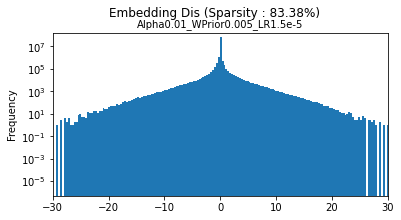

<Figure size 432x288 with 0 Axes>

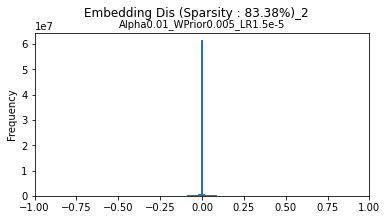

In [13]:
%%time
alpha=0.01; w_prior = 5e-3; lr = '1.5e-5'
sparsity_ratio = get_ratio_zero(embeddings)
suptitle = f'Embedding Dis (Sparsity : {sparsity_ratio*100:.2f}%)'
title  = f'Alpha{alpha}_WPrior{w_prior}_LR{str(lr)}'
save_path = f'imgs_jupyter/{suptitle}_{title}.jpg'
plot_Embedding_Dis(embeddings[::10] , bins=200, suptitle=suptitle, title=title, save_path=save_path, xlim=(-10,10),)
suptitle = f'Embedding Dis (Sparsity : {sparsity_ratio*100:.2f}%)_2'
plot_Embedding_Dis(embeddings[::10], bins=5000, suptitle=suptitle, title=title, save_path=save_path, xlim=(-1,1),logy=False)

<Figure size 432x288 with 0 Axes>

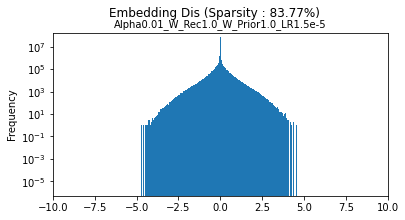

In [65]:
alpha=0.01; w_rec=1.; w_prior = 1.; lr = '1.5e-5'
sparsity_ratio = get_ratio_zero(cls_token.cpu().numpy())
suptitle = f'Embedding Dis (Sparsity : {sparsity_ratio*100:.2f}%)'
title  = f'Alpha{alpha}_W_Rec{w_rec}_W_Prior{w_prior}_LR{str(lr)}'
save_path = f'imgs_jupyter/{suptitle}_{title}.jpg'
plot_Embedding_Dis(cls_token.cpu() ,suptitle=suptitle, title=title, save_path=save_path)

<Figure size 432x288 with 0 Axes>

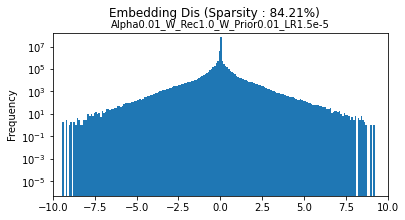

In [68]:
alpha=0.01; w_rec=1.; w_prior = 1e-2; lr = '1.5e-5'
sparsity_ratio = get_ratio_zero(cls_token.cpu().numpy())
suptitle = f'Embedding Dis (Sparsity : {sparsity_ratio*100:.2f}%)'
title  = f'Alpha{alpha}_W_Rec{w_rec}_W_Prior{w_prior}_LR{str(lr)}'
save_path = f'imgs_jupyter/{suptitle}_{title}.jpg'
plot_Embedding_Dis(cls_token.cpu() ,suptitle=suptitle, title=title, save_path=save_path)

<Figure size 432x288 with 0 Axes>

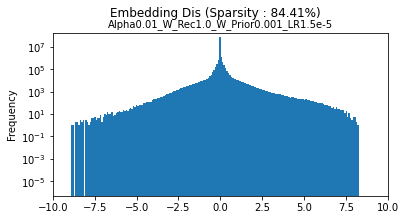

In [71]:
alpha=0.01; w_rec=1.; w_prior = 1e-3; lr = '1.5e-5'
sparsity_ratio = get_ratio_zero(cls_token.cpu().numpy())
suptitle = f'Embedding Dis (Sparsity : {sparsity_ratio*100:.2f}%)'
title  = f'Alpha{alpha}_W_Rec{w_rec}_W_Prior{w_prior}_LR{str(lr)}'
save_path = f'imgs_jupyter/{suptitle}_{title}.jpg'
plot_Embedding_Dis(cls_token.cpu() ,suptitle=suptitle, title=title, save_path=save_path)

<Figure size 432x288 with 0 Axes>

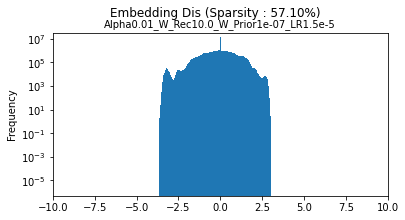

In [58]:
alpha=0.01; w_rec=10.; w_prior = 1e-7; lr = '1.5e-5'
sparsity_ratio = get_ratio_zero(cls_token.cpu().numpy())
suptitle = f'Embedding Dis (Sparsity : {sparsity_ratio*100:.2f}%)'
title  = f'Alpha{alpha}_W_Rec{w_rec}_W_Prior{w_prior}_LR{str(lr)}'
save_path = f'imgs_jupyter/{suptitle}_{title}.jpg'
plot_Embedding_Dis(cls_token.cpu() ,suptitle=suptitle, title=title, save_path=save_path)

In [135]:
%%time
df_embedding = pd.DataFrame(cls_token.cpu())
df_embedding
df_dim_stat = pd.DataFrame(columns=['mean', 'std', 'min', 'max'])
df_dim_stat  = (pd.concat([df_embedding.mean(), df_embedding.std(), df_embedding.min(), df_embedding.max()], axis=1)
            .set_axis(['mean', 'std', 'min', 'max'], axis=1)
            )

In [ ]:
alpha=0.01; w_rec=10.; w_prior = 1e-1; lr = '0.1x'
slice_ = 100
dim = cls_token.cpu().shape[-1]
for i in range(int(dim/100)+1):
    start = i*100
    end = start + slice_
    # print(start, end)
    pd.DataFrame(cls_token.cpu()[:,start:end]).plot.box(title=f'Dim : {start}-{end}', figsize=(24,2), ylim=(-5,5));

In [ ]:
# alpha=0.01; w_rec=10.; w_prior = 1e-2; lr = '0.1x'
# slice_ = 100
# dim = cls_token.cpu().shape[-1]
# for i in range(int(dim/100)+1):
#     start = i*100
#     end = start + slice_
#     # print(start, end)
#     pd.DataFrame(cls_token.cpu()[:,start:end]).plot.box(title=f'Dim : {start}-{end}', figsize=(24,1.), ylim=(-5,5));

In [45]:
embed_stat =  pd.DataFrame(cls_token.cpu()).agg(['mean','std']).T
embed_stat.describe()

,mean,std
count,768.000000,768.000000
mean,0.000951,0.066561
std,0.026767,0.104725
min,-0.362256,0.017669
25%,-0.004434,0.050334
50%,0.000376,0.056833
75%,0.004494,0.065127
max,0.531768,1.816113


<Figure size 432x288 with 0 Axes>

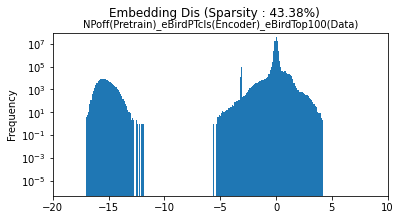

In [19]:
# plot MAE Embedding Dis
lr = '5e-4'
sparsity_ratio = get_ratio_zero(embeddings)
suptitle = f'Embedding Dis (Sparsity : {sparsity_ratio*100:.2f}%)'
title  = f'{v_embedding}'
save_path = f'imgs_jupyter/{suptitle}_{title}.jpg'
plot_Embedding_Dis(embeddings[:100000] ,suptitle=suptitle, title=title, save_path=save_path, xlim=(-20, 10))

# Embedding Distribution

In [17]:
figsize=(6,3)
title = f'EmbeddingDistribution\n{v_embedding}'
print(title)

EmbeddingDistribution
NPon(Pretrain)_eBirdFTcls(Encoder)_eBirdTop100(Data)


In [ ]:
# df_dim_stat.plot(kind='box',figsize=figsize, title=title, ylim=(-10,10));
# (df_dim_stat[['mean',
#               'max','min'
#               ]]
#  .plot(grid=True, figsize=figsize, title=title,
#      kind='hist', bins=200, logy=True, alpha=0.5,
#        xlim=(-10,10),                     
#                                        ));

In [ ]:
# figsize=(21,3)
# ax = (df_dim_stat.reset_index().rename(columns={'index':'dim'})
#  .plot.scatter(x='dim', y='mean', label='Mean',  
#      figsize=figsize, title=title, ylim=(-2,2), xlim=(0,768), grid=True)
#  )
# figsize=(21,3)
# (df_dim_stat.reset_index().rename(columns={'index':'dim'})
#  .plot.scatter(x='dim', y='std', label='Std',
#      figsize=figsize, title=title, xlim=(0,768), grid=True, c='orange', alpha=0.5,ax=ax)
#  );



In [289]:
print(f'{encoder_version.upper()}_{token}')
df_dim_stat.query('mean > 0.5 or mean <-0.5')

INATFT_cls


,mean,std,min,max


#### plot density distribution(all dims)

In [293]:
embeddings_test = np.random.randn(30,10)
print(embeddings_test.shape)
embeddings_test.reshape(-1,1).shape

(30, 10)


(300, 1)

CPU times: user 6.04 s, sys: 0 ns, total: 6.04 s
Wall time: 6.04 s


''

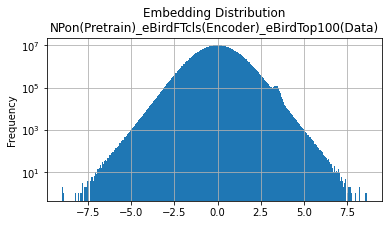

In [22]:
%%time
figsize = (6,3)
xlim=(-9, 9)
ylim=(0, 5e7)

fig, ax = plt.subplots(figsize = figsize )
ax.hist(embeddings.reshape(-1,1), bins=500)
title = f'Embedding Distribution\n{v_embedding}'

ax.grid(True)
ax.set_yscale('log')
ax.set(title=title,  ylabel='Frequency', 
       # xlim=xlim, ylim=ylim
      )
;

#### plot density distribution(dims with diff. color) 

CPU times: user 2min 37s, sys: 1.69 s, total: 2min 38s
Wall time: 2min 38s


<AxesSubplot:title={'center':'Embedding Distribution_EBIRD_PT_cls_ebird'}, ylabel='Frequency'>

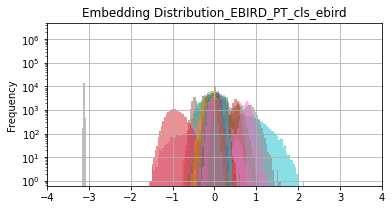

In [32]:
# %%time
# (df_embedding.plot
#    .hist(bins=500, figsize=figsize, title=title, grid=True, 
#          legend=False,  logy=True, alpha=0.5,
#          ylim=ylim,xlim=xlim,)
#     .savefig(path_embeddings/f'{title}_multi.jpg')
#       )


## Correlation btw Dimmensions

In [23]:
%%time
# matrix = df_embedding.corr()  # 13.8 s
corr_matrix = np.corrcoef(np.transpose(embeddings))
print(corr_matrix.shape)

(768, 768)
CPU times: user 3min 38s, sys: 1min 1s, total: 4min 40s
Wall time: 6.73 s


CPU times: user 877 ms, sys: 205 ms, total: 1.08 s
Wall time: 853 ms


''

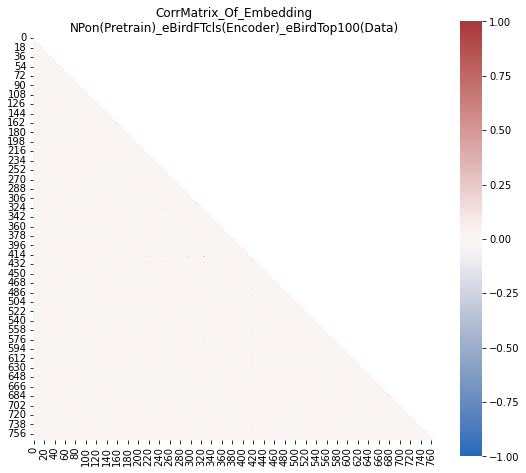

In [25]:
%%time

# 取矩陣下半三角形
mask =  np.triu(np.ones_like(corr_matrix, dtype=bool))

title = f'CorrMatrix_Of_Embedding\n{v_embedding}'
fig, ax = plt.subplots(figsize=(9, 8) )
ax.set_title(title)
sns.heatmap(corr_matrix, vmax=1, vmin=-1, center=0, square=True, 
            mask=mask,
            cmap='vlag', ax=ax)
fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)

;

CPU times: user 65.1 ms, sys: 196 µs, total: 65.3 ms
Wall time: 63.3 ms


<timed exec>:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


''

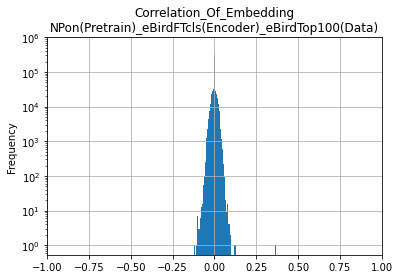

In [26]:
%%time
title = f'Correlation_Of_Embedding\n{v_embedding}'

xlim=(-1,1)
ylim=(0,1e6)
figsize = (6,4)

fig, ax = plt.subplots(figsize = figsize )
ax.hist(np.tril(corr_matrix ,k=-1).reshape(-1,1), bins=100)

ax.grid(True)
ax.set_yscale('log')
ax.set(title=title,  ylabel='Frequency',  xlim=xlim, ylim=ylim)
;
# k=-1 ，排除斜對角的數值(均為1.0) 
# fig = (pd.DataFrame(np.tril(corr_matrix ,k=-1))
#        .stack()
#        .plot(kind='hist', title=title, bins=100, grid=True, logy=True, xlim=xlim, ylim=ylim)
#       ).get_figure()
# fig.savefig(f'embedding/{title}.jpg', bbox_inches='tight',)
# ;

# Visualization of Embeddings by dimension reduction

### Labelling by Taxon

#### Data prepare

##### load embedding

In [146]:
# %%time
# file_ = f'embeddings_{model_data_version}.npz'
# print(f'{file_}')

# embeddings = np.load(path_embeddings/file_)['embedding']
# print(embeddings.shape)

embeddings_NPon(Pretrain)_eBirdFTcls(Encoder)_eBird(Data).npz
(14860, 768)
CPU times: user 261 ms, sys: 11.7 ms, total: 273 ms
Wall time: 271 ms


##### def 'cls2label()'

In [16]:
# color_mapping =
# for x in df_meta.order.unique() 

def cls2label(df_meta:pd.DataFrame, taxon:str='order')->list:
    class_ = np.sort(df_meta[taxon].unique())
    clsTolabel = dict((c_,l_) for c_, l_ in 
                 zip(class_, range(len(class_)))
                )
    labels = df_meta[taxon].map(clsTolabel).values
    # print(f'Number of classes : {len(class_)}')
    return labels

In [17]:
taxon = 'Family'

# labels = cls2label(df_meta.query('Order.notnull()'), taxon)
# print(labels.size)
# print(np.unique(labels).size)

In [1343]:
# 資料篩選 top10
topk = 11

# 排除種類最多的燕雀目('Passeriformes')後、篩選前十大目
cls_list = list(df_meta.groupby([taxon]).Sci_Name	.count()
                .sort_values(ascending=False)[:topk].index)

 
cls_list.remove('Passeriformes') 
# assert len(cls_list) == 10
print(len(cls_list))

print(len(df_meta))
mask_cls = df_meta[taxon].isin(cls_list)
print(len(df_meta[mask]))

10
896555
288920


In [205]:
title = f'UMAP_{taxon.capitalize()}(label)'
print(title)
print(model_data_version)

UMAP_Order(label)
NPon(Pretrain)_eBirdFTcls(Encoder)_eBird(Data)


##### (合併iNat與eBird資料)

In [280]:
# encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT'
# norm_pixel = 'on'

# global_pool = False
# token = 'cls' if global_pool==False else 'gap'
# data_src = 'eBird' #  'iNat', 'eBird'

# v_model_data = f'MAE_NP{norm_pixel}(Pretrain)_{encoder_version}_{token}(Encoder)_{data_src}(Data)'
# v_model_data

'MAE_NPon(Pretrain)_eBirdPT_cls(Encoder)_eBird(Data)'

In [217]:

# embeddings = [] 
# for src_ in ['iNat', 'eBird']:
#     file_ = f'embeddings_iNatureVal_{encoder_version}_{src_}.npz'
#     embeddings_ = np.load(path_embeddings/file_)['embedding']
#     embeddings.append(embeddings_)
# embeddings_pool  = np.concatenate(embeddings) 

# print(embeddings_pool.shape)
# half = int(embeddings_pool.shape[0]/2) # 14860


(29720, 768)


##### prepare labels

In [220]:
# %%time
# label_cls = 'order' # 'datasrc'

# data_src= 'pool' 
# v_model_data = f'MAE_NP{norm_pixel}_{token}(Pretrain)_{encoder_version}(Encoder)_{data_src}(Data)'
# print(f'Embedding version : {v_model_data}')

# if not label_cls.startswith('data'): 
#     labels_pool = list(labels) + list(labels)
   
#     title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{label_cls.capitalize()}(label)'
# else:
#     labels_pool = [0]*half + [1]*half
#     assert len(labels_pool) == half*2
#     title = f'UMAP projection_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_DataSrc(label)'


# print(title)

# print(f'Number of labels : {len(labels_pool)}')
# print(f'Shape of embeddingss : {embedding_umap_pool.shape}\n')

Embedding version : MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_pool(Data)
UMAP_200(n_nei)_Euc(metric)_Order(label)
Number of labels : 29720
Shape of embeddingss : (29720, 2)

CPU times: user 1.51 ms, sys: 48 µs, total: 1.56 ms
Wall time: 1.4 ms


In [221]:
# # Filter Top10 'order'

# labels_pool = list(labels[mask]) + list(labels[mask])
# print(len(labels_pool))
# title = f'UMAP_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{label_cls.capitalize()}Top10(label)'
# print(f'Embedding version : {v_model_data}')

# # labels_pool = [0]*half + [1]*half
# # assert len(labels_pool) == half*2
# # title = f'UMAP projection_{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_DataSrc(label)'


# # np.concatenate([embedding_umap[:half][mask],
# #                 embedding_umap[half:][mask]
# #                ]).shape


# print(embedding_umap_pool[list(mask) + list(mask)].shape)

12540
Embedding version : MAE_NPon_cls(Pretrain)_iNatFT(Encoder)_pool(Data)
(12540, 2)


#### Dimension reduction by UMAP

In [103]:

seed=0
# n_neighbors_ = math.ceil(df_meta.groupby([taxon]).id.count().mean())
# n_neighbors = n_neighbors_ if n_neighbors_ >=15 else 15
n_neighbors = 200 
n_components = 3
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)
print(n_neighbors)

200


In [104]:
%%time
# print(embeddings_pool.shape)
# embedding_umap_pool = reducer.fit_transform(embeddings_pool)
# print(embedding_umap_pool.shape)

print(embeddings.shape)
embedding_umap  = reducer.fit_transform(embeddings)
print(embedding_umap.shape)

(896555, 768)
UMAP(n_components=3, n_neighbors=200, random_state=0, verbose=True)
Mon Jul 18 16:43:07 2022 Construct fuzzy simplicial set
Mon Jul 18 16:48:12 2022 Finding Nearest Neighbors
Mon Jul 18 16:48:13 2022 Building RP forest with 52 trees
Mon Jul 18 16:52:53 2022 NN descent for 20 iterations
	 1  /  20
	 2  /  20
	 3  /  20
	 4  /  20
	 5  /  20
	 6  /  20
	 7  /  20
	 8  /  20
	 9  /  20
	 10  /  20
	 11  /  20
	Stopping threshold met -- exiting after 11 iterations
Mon Jul 18 18:08:30 2022 Finished Nearest Neighbor Search
Mon Jul 18 18:54:58 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


Mon Jul 18 20:01:10 2022 Finished embedding
(896555, 3)
CPU times: user 1d 9h 58min 25s, sys: 4h 10min 58s, total: 1d 14h 9min 23s
Wall time: 3h 20min 42s


In [105]:
file_ = f'embeddings_umap{n_components}D_{n_neighbors}(n_nei)_{encoder_version}{token}_{data_src}.npz'
print(file_)
np.savez_compressed(path_embeddings/file_, embedding_umap=embedding_umap )
# print(f'{file_} saved')

embedding_umap = np.load(path_embeddings/file_)['embedding_umap']
print(embedding_umap.shape)


embeddings_umap3D_200(n_nei)_eBirdFTcls_eBirdTop100.npz
(896555, 3)


#### def `plot_2DScatter_taxon()`

##### Setting colors for plot

In [281]:
# # Customized palette

# label_cls = 'order'

# if label_cls.startswith('data'):
#     palette_cus = ['#00ff00', '#0000ff']

# elif label_cls == 'order': # num_order = 32
#     palette_cus = ['#696969', '#556b2f', '#228b22', '#7f0000', '#483d8b', '#b8860b', '#008b8b', '#9acd32', '#00008b', '#7f007f', '#8fbc8f', '#b03060', '#ff4500', 
#                    '#ff8c00', '#ffd700', '#00ff00', '#9400d3', '#00ff7f', '#e9967a', '#dc143c', '#00ffff', '#00bfff', '#0000ff', '#d8bfd8', '#ff00ff', '#1e90ff', 
#                    '#f0e68c', '#90ee90', '#ff1493', '#7b68ee', '#ee82ee', '#ffffe0']
 
# print(len(palette_cus))

32


In [30]:

def plot_2DScatter_taxon(embedding, labels:np.ndarray=None, 
                   color:str='lightblue', alpha=0.3, 
                   figsize:tuple=(12,8), size=10.0 ,
                   save:bool=True, **kwds)->None:
    fig, ax = plt.subplots(figsize=figsize)

    if type(labels) == np.ndarray or type(labels) == list:
        color = [sns.color_palette(palette_cus)[l] for l in labels]
    else:
        color=color

    ax.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=color, s=size, lw=size*0.01, alpha=alpha, edgecolors='black',   
        ).get_figure()
    plt.gca().set_aspect('equal', 'datalim')

    plt.title(title, y=1.05, fontsize=14)
    plt.suptitle(f'{v_model_data}', y=0.91, fontsize=12, fontweight='light')
    # plt.figure(figsize=figsize)
    if save:
        c_ = 'mono' if type(color) == str else 'color'
        fig.savefig(f'embedding/{n_components}D_{title}_{c_}_{v_model_data}.jpg', bbox_inches='tight',)
    ;

In [ ]:
# %%time
# plot_2DScatter(embedding_umap, labels, figsize=(12,8), size=5.0 ,alpha=0.1,
#                save=True, title=title, v_model_data=v_model_data,)

In [ ]:
# %%time
# plot_Scatter2D(embedding[list(mask) + list(mask)], labels, figsize=(16,12), size=10.0 ,alpha=0.3,
#                save=True, title=title, v_model_data=v_model_data,)

#### def `plot_3DScatter_taxon()`

In [31]:
#  template ['ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none']
def convert_binary_taxon(df, cls_, taxon:str='Order') :
    df_temp = df.copy()
    df_temp[taxon] = np.where(df_temp[taxon] == cls_, cls_, 'Others' )
    df_temp[taxon] = df_temp[taxon].astype('category')
    return df_temp


def plot_3DScatter_taxon(embedding, df:pd.DataFrame, taxon:str='Order', monocolor:bool=False,
                       color_discrete_map:dict=None, 
                       opacity=0.8, width=1200, marker_size:int=2, save_file:str=None, **kwds ):
    
    df = convert_binary_taxon(df, cls_, taxon) if monocolor else df
        
    scatter_setting = dict(data_frame=embedding, x=0, y=1, z=2,
                       labels=dict(color=taxon), color=df[taxon],
                        # 設定游標顯示項目
                        hover_name= df.ML_Catalog_Number, 
                        hover_data=dict(Order=df.Order, Family=df.Family, Genus=df.Genus, 
                                        Sp=df.SCI_NAME_2021, Dir_FName=df.Dir_FName))
    if color_discrete_map is not None :
        scatter_setting.update(color_discrete_map=color_discrete_map)
        
    fig = px.scatter_3d(**scatter_setting)
    fig.update_layout(
        width=width, height=width*2/3, template='seaborn', 
        margin = dict(r=10, l=10, b=5, t=5),   # tight layout
        title = dict( text=title, x=0.5, y=0.9, font=dict(family="Arial", size=20,)),
        legend = dict(x=0.75, y=0.9, itemsizing = 'constant', bordercolor="Black", borderwidth=0.1),)
    fig.update_traces(marker_size=marker_size, opacity=opacity,)

    # fig.show()
    if save_file is not None:
        fig.write_html(save_file, auto_open=True)



#### def `sample_nontarget_idx()`
- Since the total number of data is too large, sampling is done before visualization.
- Random sampling based on the coordinates of the embedding distribution

In [34]:
%%time

# add labels accordind Distribution of values from coordinates

assert embedding_umap.shape[0] == len(df_meta) 

temp_cod = (pd.DataFrame(np.ceil(embedding_umap).astype(np.int8), dtype='str')
            .apply(lambda df : ('_').join(df), axis=1).rename('Coordinates'))
df_cod = pd.concat([temp_cod, df_meta[col_taxon]], axis=1)

# df_cod = pd.DataFrame(np.ceil(embedding_umap).astype(np.int8), dtype='str') 
# df_cod['Coordinates'] = df_cod[0] + '_' + df_cod[1] + '_' + df_cod[2]                 #  equal apply(lambda df : ('_').join(df), axis=1)) , but much slower 
# df_cod = df_cod[['Coordinates']]
# df_cod[col_taxon] = df_meta[col_taxon]

def sample_nontarget_idx(df_:pd.DataFrame=None, 
                         cls_:str=None, taxon:str='Order', p=0.1)->np.array:
    index_target = df_.query(f'{taxon} == @cls_').index.values
    index_others = df_.query(f'{taxon} != @cls_').index.values
    n_target = len(index_target)
    n_others = len(index_others)
    
    def random_choice(df):
        n =int(np.ceil(len(df)*p))                                  # number sampled.  depends by each group 
        return np.random.choice(df.index.values, n, replace=False)  # Set 'replace=False' to turn off duplicate sampling
    
    # group by 'labeels', then sample by each group. 
    # explode() : put all [idx, ...] (by each rows) into one column 
    index_others_sampled = (df_.query('~index.isin(@index_target)').groupby(['Coordinates'])
                            .apply(random_choice)
                            .explode().values)
    n_others_spl = len(index_others_sampled)
    idx_sampled = np.sort(list(index_target) +  list(index_others_sampled))
    
    info = f'{idx:3d}, {cls_:15s} | Total index sampled : {len(idx_sampled):,d} '
    info += f'| [{n_others_spl:7,d}/{n_others:7,d}]({100*n_others_spl/n_others:5.2f}%) '
    info += f'| n_target : {n_target:5,d}, n_others : {n_others:6,d}'
    print(info, end='\r')
    
    return idx_sampled 

# wall time for 1 cls_
#  for loop : 29.6s (data size : 896,555) 
#  groupby().apply() :1.51s (data size : 896,555) 

df_cod 

CPU times: user 5.74 s, sys: 36.6 ms, total: 5.78 s
Wall time: 5.78 s


,Coordinates,Order,Family,Genus,SCI_NAME_2021,Sci_Name,Parent_Species
0,0_1_12,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris
1,0_1_12,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris
2,0_1_12,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris
3,0_1_12,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris
4,0_1_12,Passeriformes,Acanthisittidae,Acanthisitta,Acanthisitta chloris,Acanthisitta chloris,Acanthisitta chloris
...,...,...,...,...,...,...,...
896550,2_2_10,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi
896551,2_2_10,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi
896552,3_3_10,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi
896553,3_3_10,Passeriformes,Zosteropidae,Zosterornis,Zosterornis whiteheadi,Zosterornis whiteheadi,Zosterornis whiteheadi


In [55]:
taxon = 'Family'
color_discrete_map = dict(zip(np.sort(df_meta[mask_taxon][taxon].unique()),
                                       px.colors.qualitative.Vivid))
print(color_discrete_map)

save_path = Path(f'embedding/umap_Taxon/')

assert len(embedding_umap[mask_taxon]) == len(df_meta[mask_taxon][taxon]), (
    f'Data size : {len(embedding_umap[mask_taxon])} is not aligned with labels {len(df_meta[mask_taxon][taxon])}')

{'Acanthisittidae': 'rgb(229, 134, 6)', 'Acanthizidae': 'rgb(93, 105, 177)', 'Accipitridae': 'rgb(82, 188, 163)', 'Acrocephalidae': 'rgb(153, 201, 69)', 'Aegithalidae': 'rgb(204, 97, 176)', 'Aegithinidae': 'rgb(36, 121, 108)', 'Aegothelidae': 'rgb(218, 165, 27)', 'Alaudidae': 'rgb(47, 138, 196)', 'Alcedinidae': 'rgb(118, 78, 159)', 'Alcidae': 'rgb(237, 100, 90)', 'Anatidae': 'rgb(165, 170, 153)'}


In [1349]:
title = f'UMAP_{taxon.capitalize()}(label)_Top10'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_embedding}'
save_file = f'{save_path}/{n_components}D_{taxon}_{title}_{subtitle}.html'
title  += f'<br><sup>{subtitle}</sup>'       #  <br><sup>  </sup> start from next line 

# sample
cls_list = list(df_meta.groupby([taxon]).Sci_Name	.count()
                .sort_values(ascending=False)[:11].index)
cls_list.remove('Passeriformes') 
mask_cls = df_meta[taxon].isin(cls_list)
idx_sampled = sample_nontarget_idx(df_cod[mask_cls], cls_='None',  p=0.4)


plot_3DScatter_taxon(embedding_umap[idx_sampled], df_meta.loc[idx_sampled] ,taxon=taxon,
                   color_discrete_map=color_discrete_map,
                   title=title, save_file=save_file,
                     marker_size=3, opacity=0.8, width=1200)

#### 以單色凸顯個別類群
##### def `plot_MonoColor2D()`

In [19]:
# plot by class
save_path = Path(f'embedding/umap_color1_{taxon}_{data_src}(Data)')
save_path.mkdir(exist_ok=True)

def plot_MonoColor2D(embedding:np.array, 
                  cls_:str, taxon:str='order', labels=labels, df=df_meta,
                  figsize:tuple=(16,12) ,size:float=15, alpha=0.7,
                  save:bool=True, save_path=save_path,  
                  **kwds
                 )->None:
    fig, ax = plt.subplots(figsize=figsize)

    # 取得單一類別的index位置 
    idx_cls_ = df[df[taxon] == cls_].index.values

    # 建立所有類別的scatter底圖
    ax.scatter(embedding[:, 0], embedding[:, 1], 
                c='lightgrey', lw=size*0.005, s=size*0.7, edgecolors='black', alpha=alpha*0.7)

    # 建立單一欲顯色的類別scatter圖
    scatter = ax.scatter(embedding[idx_cls_, 0], embedding[idx_cls_, 1],
                         c=labels[idx_cls_],
                         lw=size*0.01, s=size, edgecolors='black', cmap='Spectral', alpha=alpha)

    # 取出legen元素，圖標 handles與 標籤labels
    handles, labls = scatter.legend_elements()  # labels
    # family_list = [Fam_dic[int(labels[l].split("{")[1].split("}")[0])] for l in range(len(labels))]  # 將編碼過的數字標籤反轉換為文字
    ax.legend(
    #     *scatter.legend_elements(),
        handles=handles, 
        labels= [cls_] ,
        title=taxon, ncol=2, markerscale=1, fontsize=12)

    plt.title(title, y=1.03, fontsize=16)
    subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
    plt.suptitle(subtitle, y=0.9, fontsize=12, fontweight='light')
    plt.gca().set_aspect('equal', 'datalim')
    if save==True:
        fig.savefig(Path(save_path)/f'{n_components}D_Color1_{title}_{subtitle}.jpg', bbox_inches='tight',)
    ;



NameError: name 'labels' is not defined

##### labelling by taxon

- plot 2D

In [ ]:
# %%time
# cls_list = list(df_meta.groupby([taxon]).Sci_Name.count()
#                 .sort_values().index)
# print(len(cls_list))

# save_path = Path(f'embedding/umap_Taxon/monoColor2D/{encoder_version}_{data_src}_{taxon}')
# save_path.mkdir(exist_ok=True, parents=True)

# for cls_ in cls_list:
#     title = f'UMAP_{cls_.capitalize()}(label)'
#     plot_2D_MonoColor(embedding_umap , cls_=cls_, taxon=taxon, labels=labels, df=df_meta,
#               figsize=(16,12), size =15, alpha=0.7,
#               save=True, save_path=save_path, title=title, v_model_data=v_model_data)
#     plt.close();

- plot 3D

##### Data sampling for plotly display

- 將資料按3為空間切割成 x*y*z 個 3d小格(group) 
- 每個3d小格隨機從非目標類群取樣10%的資料點位
    - 先取出 目標類群的index
    - 再取出非目標類群的index，再從中取樣 
    - 取樣原則
        - 如果資料點少於10，則至少取1筆

- 將embedding按空間切割分組

In [74]:
 cls_list
    

['Accipitriformes', 'Anseriformes', 'Apterygiformes', 'Bucerotiformes', 'Caprimulgiformes', ..., 'Strigiformes', 'Struthioniformes', 'Suliformes', 'Tinamiformes', 'Trogoniformes']
Length: 41
Categories (41, object): ['Accipitriformes', 'Anseriformes', 'Apterygiformes', 'Bucerotiformes', ..., 'Struthioniformes', 'Suliformes', 'Tinamiformes', 'Trogoniformes']

In [77]:
taxon = 'Genus'
cls_list = df_meta[taxon].dropna().sort_values().unique()
print(f'Number of {taxon}(class) : {len(cls_list)}')

p=0.005

Number of Genus(class) : 2295


In [78]:
%%time 

color_discrete_map = {"Others": "lightgrey", 
                  # cls_:'lightblue'
                 }

save_path = Path(f'embedding/umap_Taxon/monoColor3D/{encoder_version}_{data_src}_{taxon}')
save_path.mkdir(exist_ok=True, parents=True)

for idx, cls_ in enumerate(cls_list):
    # print(idx, cls_, end='\r')
    if cls_ == 'Passeriformes':
        continue
    title = f'UMAP_{cls_.capitalize()}(label)'
    subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_embedding}'
    save_file = f'{save_path}/MC{n_components}D_{taxon}_{title}_{subtitle}.html'
    title  += f'<br><sup>{subtitle}</sup>'       #  <br><sup>  </sup> start from next line 
    
    idx_sampled = sample_nontarget_idx(df_cod, cls_, taxon, p=p)
    plot_3DScatter_taxon(embedding_umap[idx_sampled],  df_meta.loc[idx_sampled] ,taxon=taxon, 
                         monocolor=True, cls_=cls_,
                          color_discrete_map=color_discrete_map,
                       title=title, save_file=save_file,
                         marker_size=3, opacity=0.8, width=1200)
    # break

CPU times: user 16min 59s, sys: 13.2 s, total: 17min 12s 4,876/896,502]( 0.54%) | n_target :    53, n_others : 896,502274
Wall time: 17min 12s


In [1168]:
taxon= 'Order'
cls_ = 'Passeriformes'
idx_sampled = sample_nontarget_idx(df_cod, cls_, taxon)

plot_3DScatter_taxon(embedding_umap[idx_sampled][::3],  df_meta.loc[idx_sampled][::3] ,taxon=taxon, 
                     monocolor=True, cls_=cls_,
                      color_discrete_map=color_discrete_map,
                   title=title, save_file=save_file,
                     marker_size=3, opacity=0.8, width=1200)

In [1176]:
cls_ = 'Pteroglossus'
taxon= 'Genus'

save_path = Path(f'embedding/umap_Taxon/monoColor3D/{encoder_version}_{data_src}_{taxon}')
save_path.mkdir(exist_ok=True, parents=True)

title = f'UMAP_{cls_.capitalize()}(label)'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_embedding}'
save_file = f'{save_path}/MC{n_components}D_{taxon}_{title}_{subtitle}.html'
title  += f'<br><sup>{subtitle}</sup>'       #  <br><sup>  </sup> start from next line 

idx_sampled = sample_nontarget_idx(df_, cls_, taxon)

plot_3DScatter_taxon(embedding_umap[idx_sampled][::3],  df_meta.loc[idx_sampled][::3] ,taxon=taxon, 
                     monocolor=True, cls_=cls_,
                      color_discrete_map=color_discrete_map,
                   title=title, save_file=save_file,
                     marker_size=3, opacity=0.8, width=1500)

In [21]:
cls_ = 'Alcedinidae'
taxon = 'Family'

save_path = Path(f'embedding/umap_Taxon/monoColor3D/{encoder_version}_{data_src}_{taxon}')
save_path.mkdir(exist_ok=True, parents=True)

title = f'UMAP_{taxon}_{cls_.capitalize()}(label)'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_embedding}'
save_file = f'{save_path}/MC{n_components}D_{taxon}_{title}_{subtitle}.html'
title  += f'<br><sup>{subtitle}</sup>'       #  <br><sup>  </sup> start from next line 

idx_sampled = sample_nontarget_idx(df_, cls_, taxon)

plot_3DScatter_taxon(embedding_umap[idx_sampled][::3],  df_meta.loc[idx_sampled][::3] ,taxon=taxon, 
                     monocolor=True, cls_=cls_,
                      color_discrete_map=color_discrete_map,
                   title=title, save_file=save_file,
                     marker_size=3, opacity=0.8, width=1500)

NameError: name 'df_' is not defined

In [1188]:
x = np.arange(10)
x .shape
x[np.newaxis].shape
x[:,None].shape
# x.reshape(-1,1).shape

(10, 1)

- 分組取樣

##### (UMAP2PCA)

In [155]:
%%time
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=3, metric=metric,  random_state=seed, verbose=True)

embedding_umap = reducer.fit_transform(embeddings)
print(embedding_umap.shape)

pca = PCA(n_components=n_components)
embedding_PCA = pca.fit_transform(embedding_umap)
print(embedding_PCA.shape)

UMAP(n_components=3, n_neighbors=22, random_state=0, verbose=True)
Fri Jun 10 16:17:03 2022 Construct fuzzy simplicial set
Fri Jun 10 16:17:03 2022 Finding Nearest Neighbors
Fri Jun 10 16:17:03 2022 Building RP forest with 11 trees
Fri Jun 10 16:17:03 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	Stopping threshold met -- exiting after 5 iterations
Fri Jun 10 16:17:05 2022 Finished Nearest Neighbor Search
Fri Jun 10 16:17:06 2022 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:08]


Fri Jun 10 16:17:14 2022 Finished embedding
(14860, 3)
CPU times: user 1min 26s, sys: 22.4 s, total: 1min 49s
Wall time: 11.1 s


In [154]:
%%time
save_path = Path(f'embedding/umap_color1/{encoder_version}_{taxon}_UMAP2PCA')
save_path.mkdir(exist_ok=True, parents=True)

for cls_ in cls_list:
    title = f'UMAP2PCA_{taxon.capitalize()} {cls_.capitalize()}(label)'
    plot_2D_byCls(embedding_umap, df_meta, cls_, taxon=taxon, labels=labels,
              figsize=(16,12), size=15, alpha=0.7,
              save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();`

CPU times: user 13.7 s, sys: 13.8 s, total: 27.5 s
Wall time: 8.78 s


#### Labelling by Family on Genus Median

##### Genus Median

In [175]:
emb_genus_median = (pd.concat([df_meta[['family','genus']], 
                              pd.DataFrame(embeddings)], axis=1)
                   .groupby(['family', 'genus']).median()).values
print(emb_genus_median.shape)

(648, 768)


In [179]:
df_fam_genus = df_meta.groupby(['family', 'genus']).count().reset_index()[['family', 'genus']]
df_fam_genus

,family,genus
0,Acanthisittidae,Acanthisitta
1,Acanthizidae,Acanthiza
2,Acanthizidae,Gerygone
3,Acanthizidae,Sericornis
4,Accipitridae,Accipiter
...,...,...
643,Upupidae,Upupa
644,Viduidae,Vidua
645,Vireonidae,Cyclarhis
646,Vireonidae,Vireo


In [205]:
taxon = 'family'
labels = cls2label(df_fam_genus, taxon)
print(labels.size)
print(np.unique(labels).size)

648
147


##### UMAP

In [195]:
seed=0
n_neighbors_ = math.ceil(df_fam_genus.groupby(['family']).count().mean()) 
n_neighbors = n_neighbors_ if n_neighbors_ >=15 else 15
# n_neighbors = 100
print(f'n_neighbors : {n_neighbors}')
n_components=2
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)

n_neighbors : 15


In [197]:
%%time
print(emb_genus_median.shape)
embedding_umap = reducer.fit_transform(emb_genus_median)
print(embedding_umap.shape)

(648, 768)
UMAP(random_state=0, verbose=True)
Fri Jun 10 16:46:17 2022 Construct fuzzy simplicial set
Fri Jun 10 16:46:17 2022 Finding Nearest Neighbors
Fri Jun 10 16:46:17 2022 Finished Nearest Neighbor Search
Fri Jun 10 16:46:17 2022 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:01]

Fri Jun 10 16:46:18 2022 Finished embedding
(648, 2)
CPU times: user 5.23 s, sys: 5.48 s, total: 10.7 s
Wall time: 1.54 s


 ##### plot by Family on Genus Median

In [206]:
# 資料篩選 topk
topk = 30 
cls_list = list(df_meta.groupby([taxon]).id.count()
                .sort_values()[-topk :].index)

In [226]:
%%time
save_path = Path(f'embedding/umap_color1/{encoder_version}_{taxon}')
save_path.mkdir(exist_ok=True, parents=True)

for cls_ in cls_list:
    title = f'UMAP_{taxon.capitalize()} {cls_.capitalize()}(label)'
    plot_2D_byCls(embedding_umap, df_meta, cls_, taxon=taxon, 
                  labels=labels, df=df_meta,
                  figsize=(16,12), size=15, alpha=0.8,
                  save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();

CPU times: user 11.9 s, sys: 8.52 s, total: 20.4 s
Wall time: 8.99 s


### Taxon in different Latitude Zone

#### data prepare

##### load embedding

In [33]:
# load embedding
encoder_version='iNatFT' # 'iNatFT' or 'eBirdPT'
norm_pixel = 'on'

global_pool = False
token = 'cls' if global_pool==False else 'gap'
data_src = 'iNat' #  'iNat', 'eBird'

v_model_data = f'MAE_NP{norm_pixel}(Pretrain)_{encoder_version}_{token}(Encoder)_{data_src}(Data)'
print(v_model_data)

file_ = f'embeddings_iNatureVal_{encoder_version}_{data_src}.npz'
embeddings = np.load(path_embeddings/file_)['embedding']
print(embeddings.shape)


MAE_NPon(Pretrain)_iNatFT_cls(Encoder)_iNat(Data)
(14860, 768)


##### load meta

In [34]:
meta_data =  '../../shared/iNaturalist_2021/meta/val.csv'
df_meta =  pd.read_csv(meta_data, index_col=0)
# Establish sp_id 
df_meta['Sci_Name'] = df_meta.genus + '_' + df_meta.specific_epithet
sp_list = np.sort(df_meta.Sci_Name.unique())
mapping_dict = dict(zip(sp_list, range(sp_list.size)))
df_meta['sp_id'] = df_meta.Sci_Name.map(mapping_dict)

df_meta['Year'] = df_meta.date.apply(lambda x :x.split('-')[0]).astype(np.uint16)
df_meta['Month'] = df_meta.date.apply(lambda x :x.split('-')[1]).astype(np.uint8)

col_ts = ['Year','Month', 'latitude', 'longitude','location_uncertainty']
col_taxon = ['order', 'family', 'genus', 'Sci_Name']
col_sel = col_taxon + col_ts

df_meta[col_sel]
print(df_meta.columns)
print(f'# of Order : {df_meta.order.nunique()}')
print(f'# of Family : {df_meta.family.nunique()}')
print(f'# of Genus: {df_meta.genus.nunique()}')

Index(['id', 'category_id', 'width', 'height', 'file_name', 'license',
       'rights_holder', 'date', 'latitude', 'longitude',
       'location_uncertainty', 'name', 'common_name', 'supercategory',
       'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'specific_epithet', 'image_dir_name', 'Sci_Name', 'sp_id', 'Year',
       'Month'],
      dtype='object')
# of Order : 32
# of Family : 147
# of Genus: 648


In [1023]:
df_meta[col_sel].describe()

,Year,Month,latitude,longitude,location_uncertainty
count,14860.000000,14860.000000,14831.000000,14831.000000,1.268200e+04
mean,2016.442665,6.132503,15.985711,-20.095249,1.152137e+04
std,3.373034,3.220147,30.127113,91.577974,1.381098e+05
min,1975.000000,1.000000,-64.630980,-177.362550,0.000000e+00
25%,2015.000000,4.000000,-6.862830,-95.910560,3.100000e+01
50%,2018.000000,6.000000,23.740890,-65.592460,2.010000e+02
75%,2019.000000,9.000000,39.873085,35.734670,2.273750e+03
max,2019.000000,12.000000,79.936440,178.449460,1.127110e+07


In [35]:
idx = df_meta[df_meta.latitude.notnull()].index.values
df_meta = df_meta.dropna(subset=['latitude']).copy()

##### cut by latitude

In [36]:
bins = np.arange(0, 90.1, 15)
print('bins : ', bins) 
df_meta['lat_group'] = pd.cut(df_meta.latitude.abs(), bins=bins,)  # labels=list(range(len(bins[1:])))
                              
labels_ = df_meta['lat_group'].sort_values().unique()
print('Number of interval : ', len(labels_)) 
                              
intval2Int = dict(zip(labels_ , range(len(labels_)))) 
int2Intval = dict(zip(range(len(labels_)), labels_))                        

print('\n', df_meta.groupby(['lat_group']).id.count(), '\n')
labels = df_meta['lat_group'].map(intval2Int)
print(f'After transorm to int : \n{labels.unique()}')


bins :  [ 0. 15. 30. 45. 60. 75. 90.]
Number of interval :  6

 lat_group
(0.0, 15.0]     2181
(15.0, 30.0]    4402
(30.0, 45.0]    5846
(45.0, 60.0]    2200
(60.0, 75.0]     196
(75.0, 90.0]       6
Name: id, dtype: int64 

After transorm to int : 
[1, 2, 3, 0, 4, 5]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]


#### Dimension reduction by UMAP

In [37]:
n_neighbors_ = math.ceil(df_meta.groupby(['lat_group']).id.count().mean())
if n_neighbors_ > 200:
    n_neighbors = 200 
elif n_neighbors_ < 15:
    n_neighbors = 15
else:
    n_neighbors = n_neighbors_
print(n_neighbors_, n_neighbors) 

2472 200


In [38]:
seed=0
n_components=3
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)
print(n_neighbors)

200


In [39]:
%%time
# print(embeddings_pool.shape)
# embedding_umap_pool = reducer.fit_transform(embeddings_pool)
# print(embedding_umap_pool.shape)

print(embeddings.shape)
embedding_umap  = reducer.fit_transform(embeddings)
print(embedding_umap.shape)

(14860, 768)
UMAP(n_neighbors=200, random_state=0, verbose=True)
Thu Jun 16 16:32:41 2022 Construct fuzzy simplicial set
Thu Jun 16 16:32:41 2022 Finding Nearest Neighbors
Thu Jun 16 16:32:41 2022 Building RP forest with 11 trees
Thu Jun 16 16:32:42 2022 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	 5  /  14
	 6  /  14
	Stopping threshold met -- exiting after 6 iterations
Thu Jun 16 16:33:25 2022 Finished Nearest Neighbor Search
Thu Jun 16 16:33:29 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Jun 16 16:33:47 2022 Finished embedding
(14860, 2)
CPU times: user 18min 17s, sys: 12min 19s, total: 30min 37s
Wall time: 1min 6s


#### def `plot_2DScatter_Lat()`

In [40]:
def plot_2DScatter_Lat(embedding, labels:np.ndarray=None,  
                   alpha=0.3, size=10.0 , figsize:tuple=(12,8), 
                   show_legend:bool=False,
                   save:bool=True, **kwds)->None:
    
    fig, ax = plt.subplots(figsize=figsize)
    color = np.array(labels)
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                        s=size, lw=size*0.02, alpha=alpha, edgecolors='black', 
                         c=color, cmap='Spectral') 
    # Legend
    # legend = ax.legend(*scatter.legend_elements(), title="Laitude")
    # ax.add_artist(legend)
    # 取出legen元素，圖標 handles與 標籤labels
    if show_legend:
        handles, labels_ = scatter.legend_elements()  # labels
        def get_int(x): 
            return int(x.split("{")[1].split("}")[0])
        ax.legend(
            handles=handles, 
            labels = [int2Intval[get_int(labels_[l])] for l in range(len(labels_))] ,
            # labels = [int2Intval[int(labels_[l].split("{")[1].split("}")[0])] for l in range(len(labels_))] ,
            title=title_legent, markerscale=1)
    
    plt.gca().set_aspect('equal', 'datalim')

    plt.title(title, y=1.05, fontsize=14)
    subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
    plt.suptitle(subtitle, y=0.91, fontsize=12, fontweight='light')
    # plt.figure(figsize=figsize)
    if save:
        fig.savefig(f'{Path(save_path)}/{n_components}D_Laitude_{title}_{subtitle}.jpg', bbox_inches='tight',)
    ;
    

- all

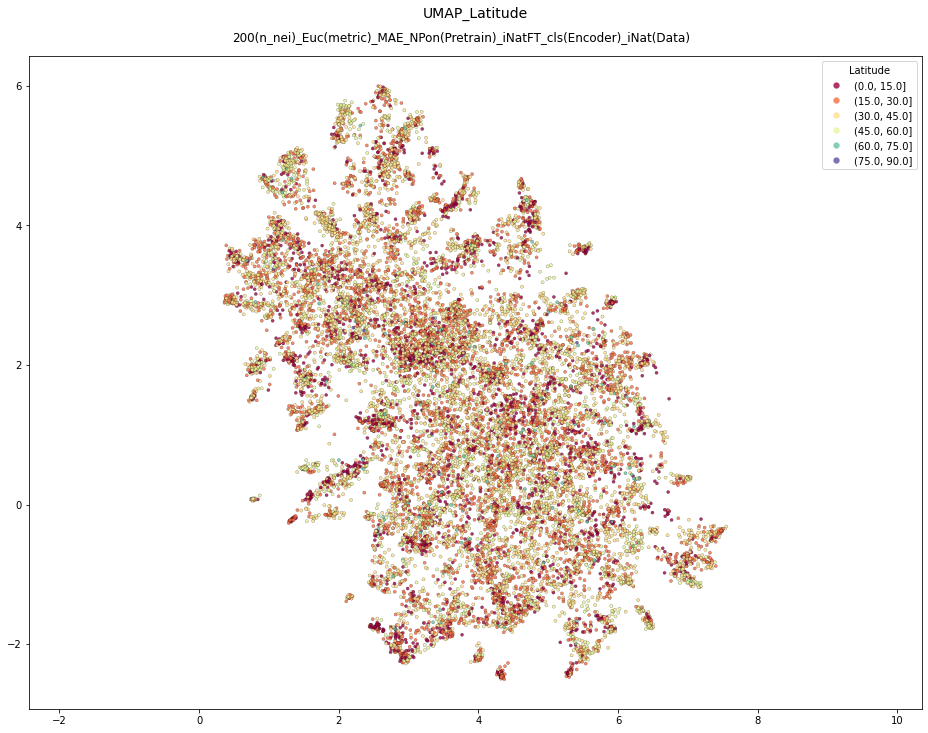

In [999]:
save_path = Path(f'embedding/umap_Latitude/{encoder_version}_{data_src}_{len(labels.unique())}(Lat)')
save_path.mkdir(exist_ok=True, parents=True)

title = f'UMAP_Latitude'
title_legent='Latitude'

plot_2DScatter_Lat(embedding_umap[idx], labels,
                   figsize=(16,12), size=10, alpha=0.8,
                   show_legend=True, title_legent=title_legent,
                   save_path=save_path, title=title, v_model_data=v_model_data)

#### def `plot_3DScatter_Lat()`

##### 3D umap

In [ ]:
%%time

seed=0
n_components=3
metric='euclidean' # 'cosine', 'euclidean' 
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, metric=metric,  random_state=seed, verbose=True)
print(n_neighbors)

print(embeddings.shape)
embedding_umap3d  = reducer.fit_transform(embeddings)
print(embedding_umap3d.shape)

In [246]:
import plotly.express as px
import plotly.graph_objects as go


def plot_3DScatter_Lat(embedding, labels, 
                       color_discrete_map:dict=None,
                      width=900, marker_size:int=2, **kwds ):
    fig = px.scatter_3d(
        embedding, x=0, y=1, z=2,
        labels=dict(color='Latitude_Zone'),
        color=labels, 
        color_discrete_map=color_discrete_map,
        # color_continuous_scale=px.colors.diverging.Spectral,
        title=title,
        opacity=0.5, 
    )

    fig.update_layout(
        width=width, height=width*2/3,
        # tight layout
        margin=dict(r=0, l=0, b=0, t=30),
        template='plotly_dark',
        legend=dict(
            x=0.8, y=1,
            itemsizing = 'constant',
            # traceorder = 'reversed', # "reversed", "grouped", "reversed+grouped", "normal"
            bordercolor="Black", borderwidth=0.1)
    )
    fig.update_traces(marker_size=2, )

    fig.show()
    fig.write_html(save_file, auto_open=True)



In [250]:
save_path = Path(f'embedding/umap_Latitude/')
title = f'UMAP_Latitude'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
save_file = f'{Path(save_path)}/{n_components}D_Laitude_{title}_{subtitle}.html'

color_discrete_map = dict(zip(np.sort(df_meta['lat_group'].unique()),
                                       px.colors.diverging.Spectral[1::2]))

plot_3DScatter_Lat(embedding_umap3d[idx], labels=df_meta['lat_group'][idx],
                   color_discrete_map=color_discrete_map,
                   marker_size=3,
                   save_file=save_file
                  )

#### Photo taken in different Latitude Zone

- 中高緯度、冬季的照片
    - latitude > 45 (about Seattle)
    - month : 12, 1

In [198]:
zone = 'High_Winter'
lat = 45
con1 =  (df_meta['latitude'] > lat ) & (df_meta['Month'].isin([12, 1]))
con2 = (df_meta['latitude'] < -lat) & (df_meta['Month'].isin([6, 7]))
idx_zone = df_meta[con1 | con2].index.values
print(len(idx_zone))
# df_meta.loc[idx_high]

174


In [1010]:
zone = 'Tropical'
lat = 15
mask =  (df_meta['latitude'] < lat)  & (df_meta['latitude'] > -lat)
idx_zone = df_meta[mask].index.values
print(len(idx_zone)


2181


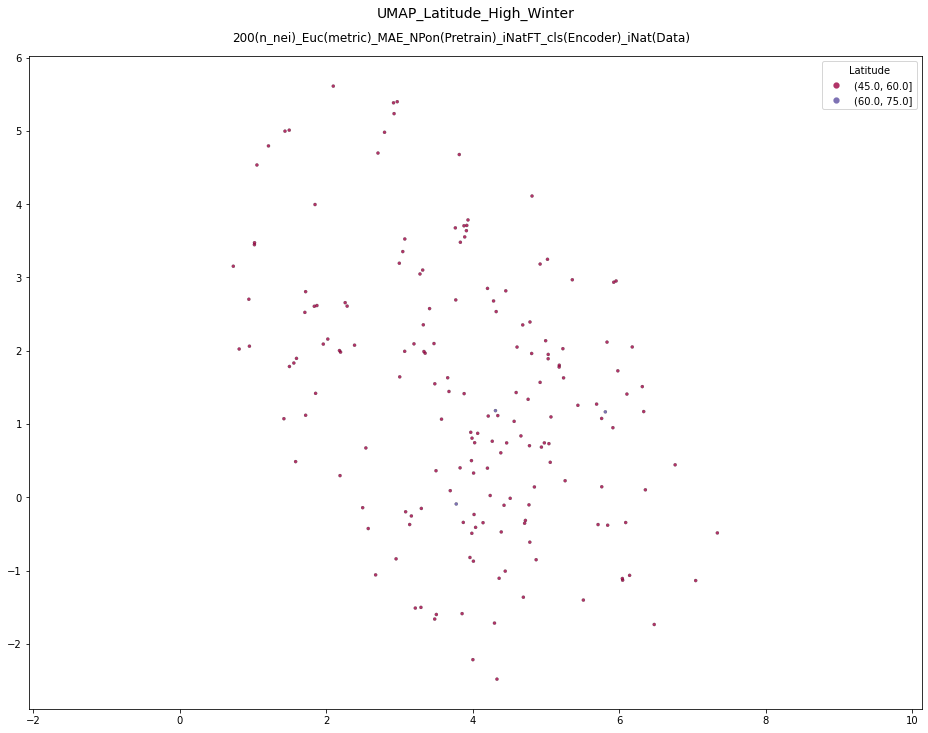

In [1018]:
save_path = Path(f'embedding/umap_Latitude/{encoder_version}_{data_src}_{len(labels.unique())}(Lat)')
save_path.mkdir(exist_ok=True, parents=True)


title = f'UMAP_Latitude_{zone}'
title_legent='Latitude'

plot_2DScatter_Lat(embedding_umap[idx_zone], labels[idx_zone],
              figsize=(16,12), size=10, alpha=0.8,
              show_legend=True, title_legent=title_legent,
            save_path=save_path, title=title, v_model_data=v_model_data)


In [249]:
save_path = Path(f'embedding/umap_Latitude/')
title = f'UMAP_Latitude_{zone}'
subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
save_file = f'{Path(save_path)}/{n_components}D_Laitude_{title}_{subtitle}.html'

color_discrete_map = dict(zip(np.sort(df_meta['lat_group'].unique()),
                                       px.colors.diverging.Spectral[1::2]))

plot_3DScatter_Lat(embedding_umap3d[idx_zone], labels=df_meta['lat_group'][idx_zone],
                   color_discrete_map=color_discrete_map,
                   marker_size=3,
                   save_file=save_file
                  )

#### Check the latitude distribution of each taxon
- Identify taxon with a wide distribution across latitudes

In [778]:
print(df_meta.columns )
# idx_order = df_meta.columns.get_loc("order")


Index(['id', 'category_id', 'width', 'height', 'file_name', 'license',
       'rights_holder', 'date', 'latitude', 'longitude',
       'location_uncertainty', 'name', 'common_name', 'supercategory',
       'kingdom', 'phylum', 'class', 'order', 'family', 'genus',
       'specific_epithet', 'image_dir_name', 'Sci_Name', 'sp_id', 'lat_group'],
      dtype='object')


In [847]:
taxon = 'genus'
# taxon = 'genus'
col_gp = ['order'] 
if taxon == 'family':
    col_gp += ['family']
elif taxon == 'genus':
    col_gp += ['family','genus']
elif taxon == 'Sci_Name':
    col_gp += ['family','genus', 'Sci_Name']
col_gp

['order', 'family', 'genus']

In [848]:
lat_dist = (df_meta.groupby(col_gp)
            .latitude.agg(['min', 'max', np.median, 'count'])
            .reset_index() )
lat_dist['range'] = lat_dist.eval('max-min')
print(len(lat_dist))
lat_dist = lat_dist.query('count>=50')
print(len(lat_dist))

lat_dist.sort_values(by=['range']).tail(15)

648
63


,order,family,genus,min,max,median,count,range
41,Anseriformes,Anatidae,Aythya,-45.97001,60.80921,38.971185,100,106.77922
8,Accipitriformes,Accipitridae,Circus,-45.84697,61.73735,45.953680,60,107.58432
146,Charadriiformes,Scolopacidae,Calidris,-38.85283,71.37447,40.437635,190,110.22730
127,Charadriiformes,Laridae,Chroicocephalus,-50.33997,60.97524,-25.277805,90,111.31521
294,Passeriformes,Emberizidae,Emberiza,-43.04371,68.33174,43.442370,90,111.37545
121,Charadriiformes,Haematopodidae,Haematopus,-46.94876,64.87177,-33.760900,80,111.82053
379,Passeriformes,Motacillidae,Anthus,-44.20813,68.36544,36.413495,110,112.57357
40,Anseriformes,Anatidae,Anser,-34.55694,78.20860,42.156545,80,112.76554
230,Gruiformes,Rallidae,Fulica,-53.11604,60.71711,-11.182350,50,113.83315
590,Podicipediformes,Podicipedidae,Podiceps,-52.71919,61.56210,43.556185,50,114.28129


#### def `plot_Lat_taxon()`

In [830]:
# plot by class

def plot_Lat_taxon(embedding:np.array,
                  cls_:str, taxon:str=None, labels=labels, df=df_meta,
                  figsize:tuple=(16,12) ,size:float=15, alpha=0.7,
                  save:bool=True, save_path=save_path,  
                  **kwds
                 )->None:
    fig, ax = plt.subplots(figsize=figsize)

    # 取得單一類別的index位置 
    idx_cls_ = df[df[taxon] == cls_].index.values

    # 建立所有類別的scatter底圖
    ax.scatter(embedding[:, 0], embedding[:, 1], 
                c='lightgrey', lw=size*0.005, s=size*0.7, edgecolors='black', alpha=alpha*0.7)

    # 建立單一欲顯色的類別scatter圖
    color = np.array(labels[idx_cls_])
    scatter2 = ax.scatter(embedding[idx_cls_, 0], embedding[idx_cls_, 1],
                        s=size, lw=size*0.02, alpha=alpha, edgecolors='black', 
                        c=color, cmap='Spectral') 

    # 取出legen元素，圖標 handles與 標籤labels
    handles, labels_ = scatter2.legend_elements()  # labels
    ax.legend(handles=handles, 
              labels = [int2Intval[get_int(labels_[l])] for l in range(len(labels_))] ,
              title="Laitude", markerscale=2, fontsize=12 )

    plt.title(title, y=1.03, fontsize=16)
    subtitle = f'{n_neighbors}(n_nei)_{metric[:3].capitalize()}(metric)_{v_model_data}'
    plt.suptitle(subtitle, y=0.9, fontsize=12, fontweight='light')
    plt.gca().set_aspect('equal', 'datalim')
    if save==True:
        fig.savefig(Path(save_path)/f'{n_components}D_Color1_{title}_{subtitle}.jpg', bbox_inches='tight',)
    ;



In [839]:
 
cls_list = lat_dist.sort_values(by=['range']).tail(30)[taxon].values
print(len(cls_list))

save_path = Path(f'embedding/umap_latitude_taxon/{encoder_version}_{data_src}_{len(labels.unique())}(Lat)_{taxon}')
save_path.mkdir(exist_ok=True, parents=True)

30


In [840]:
%%time

for cls_ in cls_list:
    title = f'UMAP_Latitude_{taxon}_{cls_}'
    plot_Lat_taxon(embedding_umap , cls_, taxon=taxon, df=df_meta,
              figsize=(16,12), size =15, alpha=0.7,
              save=True, save_path=save_path, title=title, v_model_data=v_model_data)
    plt.close();

CPU times: user 7.16 s, sys: 5.1 s, total: 12.3 s
Wall time: 5.39 s


---

# Predict bird sps

In [94]:
files_path_ = ['temp/peloci_bird_sk.jpg'] ; labels =[0]

In [95]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

batch_size =  1

mean, std = IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
# simple augmentation
transform_toTensor = transforms.Compose([transforms.Resize(256, interpolation=PIL.Image.BICUBIC), 
                                         transforms.CenterCrop(224), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean, std)])


dataset = datasets.ImageDatasetFromFile(files_path_, labels, transform=transform_toTensor)
print(len(dataset))

# sampler = torch.utils.data.RandomSampler(dataset)
data_loader = torch.utils.data.DataLoader(
        dataset, pin_memory=True, drop_last=False, shuffle=False,
        num_workers=10,  batch_size=batch_size,)
print(len(data_loader))

1
1


In [96]:
%%time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
encoder.eval()
topk = 5

with torch.no_grad():
    for images, target in  data_loader :
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        output = encoder(images).cpu().detach()
        scores, preds =  output.topk(topk) 
preds

CPU times: user 40.1 ms, sys: 807 ms, total: 847 ms
Wall time: 1.12 s


tensor([[ 5842,  8829,  1324, 10070,  4405]])

In [97]:
sp_preds = []
for label_ in preds.reshape(-1,).numpy():
    sp = df_meta.query('Label==@label_').Parent_Species.unique() 
    sp_preds.append(list(sp))
sp_preds

[['Brachypteryx goodfellowi'],
 ['Myadestes palmeri'],
 ['Charadrius alexandrinus'],
 ['Melanerpes flavifrons'],
 ['Loxia curvirostra x Spinus pinus']]

In [85]:
['Brachypteryx goodfellowi'], 小翼鶇
 ['Myadestes palmeri'],小考岛鸫
 ['Charadrius alexandrinus'],東方環頸鴴

tensor([[10.6102,  5.3751,  5.2140,  5.0673,  5.0602]])

In [ ]:
coca_sk
[['Tyto alba'],  倉鴞
 ['Pterodroma cervicalis'],白翎海燕
 ['Egretta caerulea'],小藍鷺
 ['Aptenodytes forsteri'],
 ['Rissa tridactyla']]

In [ ]:


[['Columba rupestris'], 家鴿
 ['Delichon nipalense'],黑喉毛腳燕
 ['Hydrobates pelagicus'],暴風海燕
 ['Fregetta tropica'],
 ['Garrodia nereis']]